In [33]:
!pip install LTNtorch

In [34]:
# Código 1
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import ltn
import random
#import ltn as ltntorch
import numpy as np
import matplotlib.pyplot as plt

# Configura o LTNtorch para usar o dispositivo (GPU se disponível)
ltn.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {ltn.device}")

class MLP(nn.Module):
    """Define um Perceptron Multicamadas (MLP) simples."""
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid() # Sigmoid força a saída para [0, 1]

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

Usando dispositivo: cpu


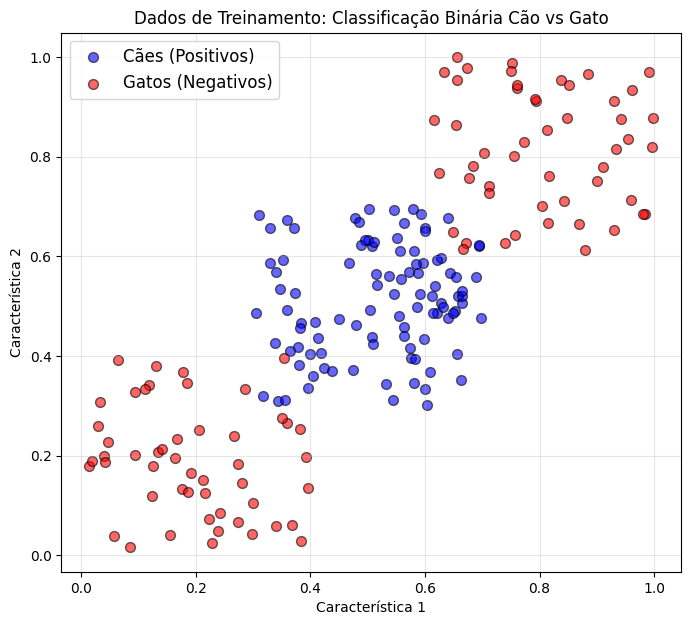

Dados Positivos (Cães): torch.Size([100, 2])
Dados Negativos (Gatos): torch.Size([100, 2])


In [35]:
# Gerando dados de exemplo para classificação binária Gato vs Cachorro
# Classe Positiva (Cães) - Centro (0.5, 0.5)
data_pos = (torch.rand((100, 2)) * 0.4 + 0.3).to(ltn.device)

# Classe Negativa (Gatos) - Pontos fora do centro
data_neg_1 = (torch.rand((50, 2)) * 0.4).to(ltn.device)
data_neg_2 = (torch.rand((50, 2)) * 0.4 + 0.6).to(ltn.device)
data_neg = torch.cat((data_neg_1, data_neg_2)).to(ltn.device)

# Visualização dos dados (movendo para CPU para matplotlib)
plt.figure(figsize=(8, 7))
plt.scatter(data_pos.cpu()[:, 0], data_pos.cpu()[:, 1], label='Cães (Positivos)', c='blue', s=50, alpha=0.6, edgecolors='k')
plt.scatter(data_neg.cpu()[:, 0], data_neg.cpu()[:, 1], label='Gatos (Negativos)', c='red', s=50, alpha=0.6, edgecolors='k')
plt.title('Dados de Treinamento: Classificação Binária Cão vs Gato')
plt.xlabel('Característica 1')
plt.ylabel('Característica 2')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

print(f"Dados Positivos (Cães): {data_pos.shape}")
print(f"Dados Negativos (Gatos): {data_neg.shape}")

In [37]:
# Define o Predicado Dog
# Ele usa nosso MLP para mapear uma entrada de 2D para 1D (valor de verdade)
Dog_model = MLP(2, 16, 1).to(ltn.device)
Dog = ltn.Predicate(Dog_model)

In [38]:
# Define os Agregadores e Otimizador
# Define logical operators
Not = ltn.Connective(ltn.fuzzy_ops.NotStandard())
And = ltn.Connective(ltn.fuzzy_ops.AndProd())
Or = ltn.Connective(ltn.fuzzy_ops.OrProbSum())
Implies = ltn.Connective(ltn.fuzzy_ops.ImpliesReichenbach())
Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=2), quantifier="f")
Exists = ltn.Quantifier(ltn.fuzzy_ops.AggregPMean(p=2), quantifier="e")
# SatAgg (Agregador de Satisfação) calculará a satisfação total da KB
sat_agg = ltn.fuzzy_ops.SatAgg()
# Otimizador padrão do PyTorch
optimizer = torch.optim.Adam(A.parameters(), lr=0.001)

In [39]:
# Define o Predicado Dog (binário: cachorro ou não)
Dog = ltn.Predicate(A_model)  # Reutiliza o mesmo modelo treinado

# Define operadores lógicos para o classificador binário
Not_binary = ltn.Connective(ltn.fuzzy_ops.NotStandard())
Forall_binary = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=2), quantifier="f")
SatAgg_binary = ltn.fuzzy_ops.SatAgg()

# Redefine o otimizador para o classificador binário
optimizer_binary = torch.optim.Adam(Dog.parameters(), lr=0.001)

# Base de Conhecimento para Classificação Binária
print("\n=== Treinamento do Classificador Binário: Gato vs Cachorro ===\n")

for epoch in range(500):  # Menos épocas pois já tem pré-treinamento
    optimizer_binary.zero_grad()

    # Variáveis LTN: exemplos positivos (cães) e negativos (gatos)
    dogs = ltn.Variable("dogs", data_pos)      # Cães = classe positiva
    cats = ltn.Variable("cats", data_neg)      # Gatos = classe negativa

    # Axiomas da Base de Conhecimento
    axiom_dogs = Forall_binary(dogs, Dog(dogs))           # ∀x ∈ cães: Dog(x) = verdadeiro
    axiom_cats = Forall_binary(cats, Not_binary(Dog(cats))) # ∀x ∈ gatos: ¬Dog(x) = verdadeiro

    # Satisfação total
    sat_binary = SatAgg_binary(axiom_dogs, axiom_cats)

    # Perda
    loss_binary = 1.0 - sat_binary

    # Backpropagation
    loss_binary.backward()
    optimizer_binary.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Satisfação: {sat_binary.item():.4f}, Perda: {loss_binary.item():.4f}")

print("\n✓ Classificador Binário Treinado com Sucesso!")


=== Treinamento do Classificador Binário: Gato vs Cachorro ===

Epoch 0: Satisfação: 0.4883, Perda: 0.5117
Epoch 50: Satisfação: 0.4986, Perda: 0.5014
Epoch 100: Satisfação: 0.5023, Perda: 0.4977
Epoch 150: Satisfação: 0.5045, Perda: 0.4955
Epoch 200: Satisfação: 0.5079, Perda: 0.4921
Epoch 250: Satisfação: 0.5132, Perda: 0.4868
Epoch 300: Satisfação: 0.5208, Perda: 0.4792
Epoch 350: Satisfação: 0.5305, Perda: 0.4695
Epoch 400: Satisfação: 0.5424, Perda: 0.4576
Epoch 450: Satisfação: 0.5560, Perda: 0.4440

✓ Classificador Binário Treinado com Sucesso!


In [40]:
grid_size = 20
x_grid = np.linspace(0, 1, grid_size)
y_grid = np.linspace(0, 1, grid_size)
xx, yy = np.meshgrid(x_grid, y_grid)
grid_points = np.stack([xx.ravel(), yy.ravel()], axis=1)
grid_torch = torch.tensor(grid_points, dtype=torch.float32).to(ltn.device)

In [41]:
def create_predicate(model):
    class PredicateWrapper(nn.Module):
        def forward(self, x, y):
            # Handle LTNObjects
            x_val = x.value if hasattr(x, 'value') else x
            y_val = y.value if hasattr(y, 'value') else y

            # Your logic here
            output = model(x_val, y_val)

            # Ensure output is in [0, 1] and correct shape
            return torch.sigmoid(output.squeeze())

    return ltn.Predicate(PredicateWrapper())

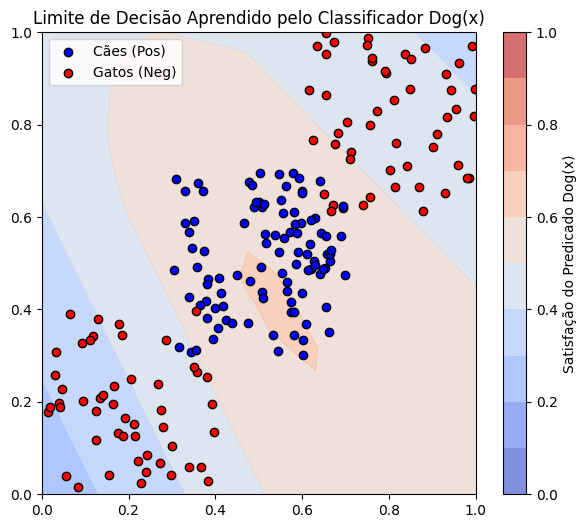

In [42]:
# Visualização da Grade de Decisão
grid_size = 20
x_grid = np.linspace(0, 1, grid_size)
y_grid = np.linspace(0, 1, grid_size)
xx, yy = np.meshgrid(x_grid, y_grid)
grid_points = np.stack([xx.ravel(), yy.ravel()], axis=1)
grid_torch = torch.tensor(grid_points, dtype=torch.float32).to(ltn.device)

# Obtém a predição (valor de verdade) para cada ponto na grade
with torch.no_grad():
    # Envolva grid_torch em ltn.Variable
    truth_values = Dog(ltn.Variable('grid_points', grid_torch))

# Remodela para o formato da grade (acessando o valor do LTNObject)
zz = truth_values.value.reshape(xx.shape)

# Plota o limite de decisão (heatmap de satisfação)
plt.figure(figsize=(7, 6))
plt.contourf(xx, yy, zz, levels=np.linspace(0, 1, 11), cmap="coolwarm", alpha=0.7)
plt.colorbar(label='Satisfação do Predicado Dog(x)')
# Plota os dados de treinamento originais por cima
plt.scatter(data_pos.cpu()[:, 0], data_pos.cpu()[:, 1], label='Cães (Pos)', c='blue', edgecolors='k')
plt.scatter(data_neg.cpu()[:, 0], data_neg.cpu()[:, 1], label='Gatos (Neg)', c='red', edgecolors='k')
plt.title('Limite de Decisão Aprendido pelo Classificador Dog(x)')
plt.legend()
plt.show()